# Projet d'analyse des résultats des détections des exoplanètes par le télescope Kepler

Source : This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
Tue Jan 23 10:50:14 2024

### Objectif :
A partir de la validité des résultats de détection des exoplanètes par le télescope Kepler obtenir un modèle de prédiction de la probabilité d'avoir un exoplanète sur une planète Terrestre.

### Modèle CNN 1D
Usage de GridSearchCV pour optimiser les hyperparamètres du modèle.

Au 28/01/2024 : Best: 0.942642 using {'activation': 'relu', 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'optimizer': 'adam'}


In [29]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import seaborn as sns

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model, save_model

from keras.wrappers.scikit_learn import KerasClassifier



In [30]:

# Charger ensemble de données ici (new_data par exemple)
new_data = pd.read_csv('./dataset/data_resampled.csv')
new_data.head()

,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_smet,koi_smet_err1,koi_smet_err2,koi_srad,...,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err,target
0,4499.0,89.0,-89.0,4.635,0.032,-0.020,-0.26,0.15,-0.15,0.639,...,0.210,0.210,0.190,-0.41,0.180,-0.43,0.220,0.59,0.190,1
1,5365.0,191.0,-175.0,3.669,0.816,-0.204,-0.04,0.30,-0.30,2.872,...,0.076,14.558,0.099,-13.90,0.072,4.37,0.081,14.57,0.077,0
2,6014.0,190.0,-211.0,4.436,0.072,-0.217,-0.04,0.25,-0.30,1.021,...,0.620,0.500,0.980,0.14,0.930,-0.40,0.620,0.42,0.860,1
3,4498.0,90.0,-90.0,4.661,0.012,-0.042,-0.08,0.15,-0.15,0.635,...,0.270,0.130,0.600,0.58,0.710,-0.25,0.270,0.63,0.590,1
4,5839.0,105.0,-105.0,4.327,0.156,-0.104,-0.28,0.15,-0.15,1.067,...,0.630,0.570,0.580,0.40,0.610,0.12,0.730,0.41,0.570,1


In [31]:

# Séparation des caractéristiques (X) et de la cible (y)
X = new_data.drop('target', axis=1)
y = new_data['target']

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:

# Normalisation des caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Reshape des données pour convenir à l'entrée d'un CNN
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


Les modèles

In [33]:
def create_model(filters, kernel_size, activation, optimizer):
    model = keras.Sequential([
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(X_train_scaled.shape[1], 1)),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=filters*2, kernel_size=kernel_size, activation=activation),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation=activation),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model



In [34]:
modele_nom = 'model_grid_3'

In [35]:
# ---- Callback tensorboard


log_dir = "./logs/tb_" + modele_nom + "_" + datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./models/best-"+modele_nom+".h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./models/"+modele_nom+"-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath('./logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir d:\David\Documents\workspace python\ML\Kepler-planets\logs


chargement du modèle

In [36]:

# Convertir le modèle Keras en modèle compatible avec scikit-learn
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0, callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback])

# Définir la grille des hyperparamètres
param_grid = {
    'filters': [64,128],
    'kernel_size': [3],
    'activation': ['relu'],
    'optimizer': ['adam'],
    'epochs': [30]
}


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23188\3858710903.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0, callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback])


In [37]:

# Compilation du modèle
# Créer la grille de recherche
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid.fit(X_train_scaled, y_train)

# Afficher les résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Best: 0.942642 using {'activation': 'relu', 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'optimizer': 'adam'}

65/65 [==============================] - 1s 15ms/step
Best: 0.942642 using {'activation': 'relu', 'epochs': 30, 'filters': 64, 'kernel_size': 3, 'optimizer': 'adam'}


#### Evaluation

In [40]:

# Évaluation du modèle
# Récupérer le meilleur modèle
best_model = grid_result.best_estimator_.model
y_pred = best_model.predict(X_test_reshaped)

# Convertir les probabilités en classes binaires en utilisant un seuil (0.5 dans cet exemple)
y_pred_binary = (y_pred > 0.5).astype(int)


best_model.save('./models/best-'+modele_nom)

49/49 [==============================] - 1s 10ms/step


INFO:tensorflow:Assets written to: ./models/best-model_grid_3\assets


INFO:tensorflow:Assets written to: ./models/best-model_grid_3\assets


val_accuracy: 0.9511568123393316


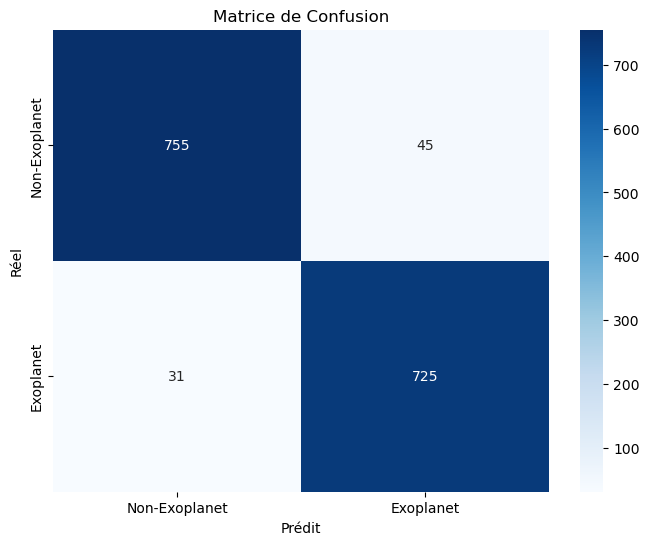

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       800
           1       0.94      0.96      0.95       756

    accuracy                           0.95      1556
   macro avg       0.95      0.95      0.95      1556
weighted avg       0.95      0.95      0.95      1556



In [42]:

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

print(f'val_accuracy: {accuracy}')

# Affichage de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_binary)
# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Exoplanet', 'Exoplanet'],
            yticklabels=['Non-Exoplanet', 'Exoplanet'])
plt.title('Matrice de Confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()

# Affichage du rapport de classification
class_report = classification_report(y_test, y_pred_binary)
print('Classification Report:')
print(class_report)